In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

from federate import federated_train
from utils import compute_metrics


import torch

from datasets import Dataset
from transformers import AutoTokenizer, Trainer, AutoModelForSequenceClassification, TrainingArguments
print(torch.__version__)
print(torch.cuda.is_available())


2.6.0+cpu
False


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
# MODEL_PATH = "mBERT" # I have donloaded distilled mBERT (hugggingface not available in China)
MODEL_PATH = "distilbert-base-multilingual-cased"
DATA_DIR = "data"


In [4]:
def load_and_label(filepath, portion=0.1):
    df = pd.read_csv(filepath).sample(frac=portion, random_state=42)
    # Map stars to 0/1/2
    def map_sentiment(stars):
        if stars <= 2:
            return 0  # negative
        elif stars == 3:
            return 1  # neutral
        else:
            return 2  # positive
    df["label"] = df["stars"].apply(map_sentiment)
    return Dataset.from_pandas(df[["review_body", "label", "language"]])

train_ds = load_and_label(os.path.join(DATA_DIR, "train.csv"))
val_ds = load_and_label(os.path.join(DATA_DIR, "validation.csv"))
test_ds = load_and_label(os.path.join(DATA_DIR, "test.csv"))


In [5]:

# ==== Tokenizer ====
print("Loading tokenizer from local path...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

def tokenize(example):
    return tokenizer(example["review_body"], truncation=True, padding="max_length",max_length=512)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

columns_to_keep = ["input_ids", "attention_mask", "label", "language"]
train_ds.set_format(type="torch", columns=columns_to_keep)
val_ds.set_format(type="torch", columns=columns_to_keep)
test_ds.set_format(type="torch", columns=columns_to_keep)


Loading tokenizer from local path...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [6]:
train_ds.to_pandas()

,review_body,label,language,__index_level_0__,input_ids,attention_mask
0,Love it! Not because it works well on my baby ...,2,en,372605,"[101, 11248, 10271, 106, 16040, 12373, 10271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Un poco pequeña para el coche donde la instalé...,2,es,551204,"[101, 11038, 14445, 31630, 10220, 10125, 61429...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,I used about 30-40 pumps of this and it made s...,0,en,240320,"[101, 146, 11031, 10978, 10244, 118, 10533, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,一拿到表的时候，还算好看，但是表盘背后有十分多的划痕，就是那种被磨损的痕迹，一看就不是新货，...,0,zh,1047361,"[101, 2072, 4096, 2555, 7082, 5718, 4356, 2339...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Regalo. Esta bien pero hubiera sido mejor si s...,2,es,555362,"[101, 107990, 22219, 119, 13666, 12028, 11266,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...
119995,千万不要买海外购，东西寄回去两个月了还没退钱,0,zh,1015016,"[101, 2667, 2075, 2080, 7139, 2140, 5005, 3189...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
119996,Vom Aussehen sehr gut !!!!Leider keinerlei bes...,2,de,145198,"[101, 30741, 18290, 65197, 14483, 23639, 106, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
119997,拆开包装后后，整个茶饼非常松散，根本不需要茶刀。碎茶很多。真心怀疑是否是中粮的茶。,0,zh,1023826,"[101, 4058, 3701, 2643, 7104, 2775, 2775, 1006...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
119998,いつも安いビニール傘を使ってるが、こちの方は全然違う。使いやすいし、骨もしっかりした感じです...,2,ja,987529,"[101, 1906, 26554, 13291, 3378, 1906, 71110, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [7]:
from collections import Counter

def plot_original_distribution(df):
    language_counts = df['language'].value_counts().reset_index()
    language_counts.columns = ['language', 'count']
    language_counts = language_counts.sort_values(by='language') 
    
    plt.figure(figsize=(5, 2.5))
    sns.barplot(data=language_counts, x='language', y='count', hue='language', palette='viridis', legend=False)
    
    for i, count in enumerate(language_counts['count']):
        plt.text(i, count, str(count), ha='center', va='bottom', fontsize=8)
    
    plt.title("Overall Distribution", fontsize=10)
    plt.xlabel("Language", fontsize=9)
    plt.ylabel("Samples", fontsize=9)
    plt.xticks(rotation=45, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_language_distribution(datasets, df):
    for client_id, subset in enumerate(datasets):
        labels = [df[idx]["language"] for idx in subset.indices]
        label_counts = Counter(labels)

        # Format as DataFrame
        language_counts = pd.DataFrame({
            'language': list(label_counts.keys()),
            'count': list(label_counts.values())
        }).sort_values(by='language')

        # Plot
        plt.figure(figsize=(5, 2.5))
        sns.barplot(data=language_counts, x='language', y='count', hue='language', palette='viridis', legend=False)

        for i, count in enumerate(language_counts['count']):
            plt.text(i, count, str(count), ha='center', va='bottom', fontsize=8)

        plt.title(f"Client {client_id+1} - Language Distribution", fontsize=10)
        plt.xlabel("Language", fontsize=9)
        plt.ylabel("Samples", fontsize=9)
        plt.xticks(rotation=45, fontsize=8)
        plt.yticks(fontsize=8)
        plt.tight_layout()
        plt.show()

In [8]:
from torch.utils.data import Dataset, Subset
from collections import defaultdict
import numpy as np

def get_indexes_per_language(df: Dataset):
    lang_to_indices = defaultdict(list)

    for idx in range(len(df)):
        lang = df[idx]["language"]
        lang_to_indices[lang].append(idx)
    return lang_to_indices

def uniform_split(df: Dataset, lang_to_indices, num_clients=4):
    client_indices = [[] for _ in range(num_clients)]

    for label, indices in lang_to_indices.items():
        np.random.shuffle(indices)
        split_sizes = [len(indices) // num_clients] * num_clients
        for i in range(len(indices) % num_clients):
            split_sizes[i] += 1

        start = 0
        for client_id, size in enumerate(split_sizes):
            end = start + size
            client_indices[client_id].extend(indices[start:end])
            start = end

    datasets = [Subset(df, sorted(indices)) for indices in client_indices]
    return datasets

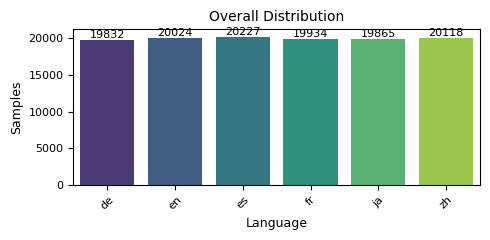

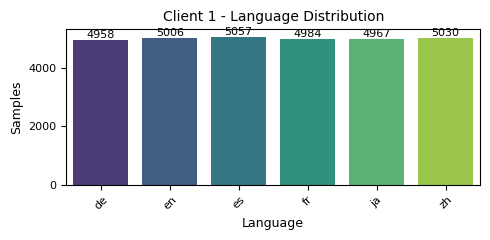

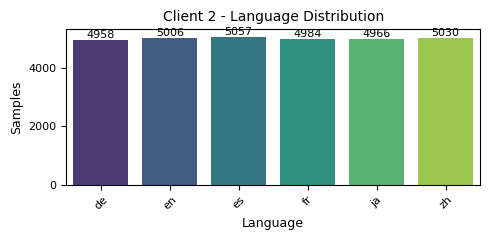

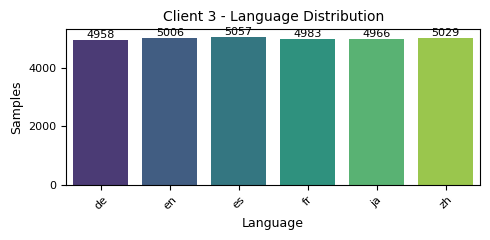

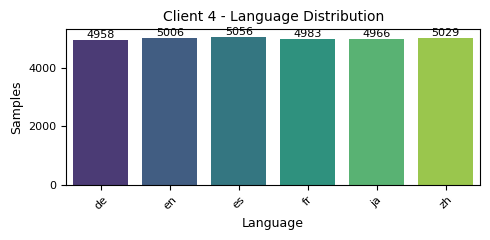

In [9]:
lang_to_indices = get_indexes_per_language(train_ds)
plot_original_distribution(train_ds.to_pandas())
plot_language_distribution(uniform_split(train_ds, lang_to_indices), train_ds)

In [12]:
def dirichlet_split(df: Dataset, lang_to_indices, beta: float, num_clients=4):
    client_indices = [[] for _ in range(num_clients)]

    for label, indices in lang_to_indices.items():
        np.random.shuffle(indices)
        proportions = np.random.dirichlet([beta] * num_clients)
        proportions = (proportions * len(indices)).astype(int)

        # Fix rounding issues
        diff = len(indices) - np.sum(proportions)
        for i in range(diff):
            proportions[i % num_clients] += 1

        # Allocate indices
        start = 0
        for client_id, count in enumerate(proportions):
            end = start + count
            client_indices[client_id].extend(indices[start:end])
            start = end

    datasets = [Subset(df, sorted(indices)) for indices in client_indices]
    return datasets

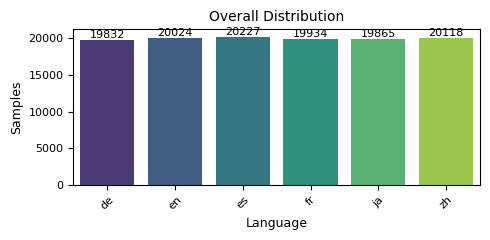

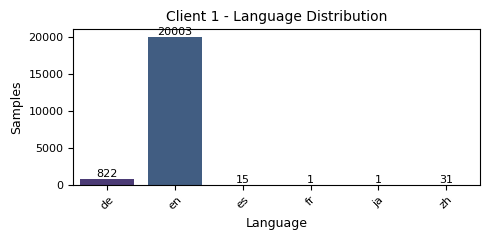

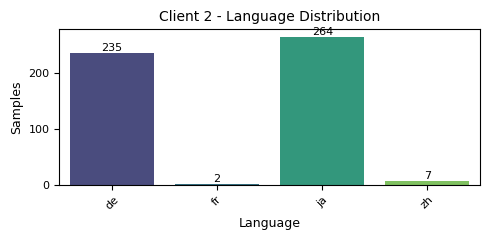

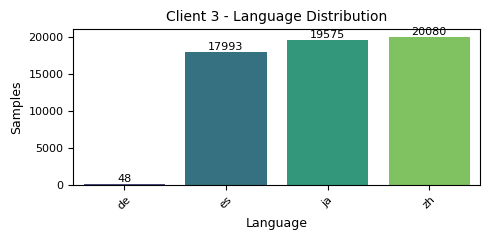

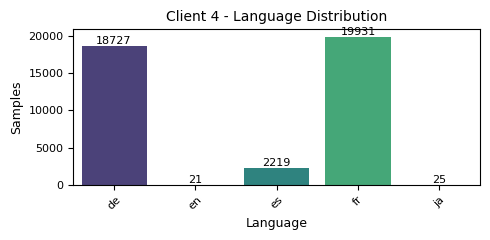

In [15]:
plot_original_distribution(train_ds.to_pandas())
plot_language_distribution(dirichlet_split(train_ds, lang_to_indices, beta=0.1), train_ds)

In [ ]:
n = len(train_ds)
subset_size = n // 4

client_datasets = [
    train_ds.select(range(0, subset_size)),
    train_ds.select(range(subset_size, 2 * subset_size)),
    train_ds.select(range(2 * subset_size, 3 * subset_size)),
    train_ds.select(range(3 * subset_size, 4 * subset_size)),
]

In [ ]:

NUM_LABELS = 3

# ==== Load Model ====
print("Loading model from local path...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=NUM_LABELS)

# ==== Metrics ====


BATCH_SIZE = 32
EPOCHS = 3




In [ ]:
# federated_train(
#     base_model=model,
#     client_datasets=client_datasets,
#     val_ds=val_ds,
#     test_ds=test_ds,
#     client_weights=[0.25,0.25,0.25,0.25],
#     local_epochs=2,
#     global_rounds=3,
#     batch_size=BATCH_SIZE,
#     learning_rate=5e-5,
#     device=device
# )